In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/clouddataset17/dec12_18features.csv
/kaggle/input/clouddataset17/nineteenFeaturesDf.csv


In [7]:
import os
import random
import math
import gc
import io
import json
import tempfile
from datetime import datetime, timezone
from pathlib import Path
from typing import Dict, Iterable, List, Optional, Tuple

import pandas as pd
import numpy as np


from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.mixture import GaussianMixture


import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

print("tensorflow:", tf.__version__)


INPUT_PATH = "/kaggle/input/clouddataset17/dec12_18features.csv"
OUTPUT_DIR = Path("/kaggle/working")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
STATE_PATH = OUTPUT_DIR / "arf_tc_state.json"


def set_deterministic(seed: int = 42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    try:
        tf.random.set_seed(seed)
    except Exception:
        pass
    os.environ["OMP_NUM_THREADS"] = "1"
    os.environ["OPENBLAS_NUM_THREADS"] = "1"
    os.environ["MKL_NUM_THREADS"] = "1"
    os.environ["NUMEXPR_NUM_THREADS"] = "1"
    os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

set_deterministic(42)
print("📌 Deterministic helpers set; Kaggle working directory:", OUTPUT_DIR)


def nowstamp():
    return datetime.now(timezone.utc).strftime("%Y-%m-%dT%H-%M-%SZ")

def load_state(default_models: Iterable[str], state_path: Path = STATE_PATH):
    if state_path.exists():
        st = json.loads(state_path.read_text())
        st.setdefault("R", {})
        for m in default_models:
            if m not in st["R"]:
                st["R"][m] = 0.5
        st.setdefault("S_prev", {})
        return st
    else:
        st = {"R": {m: 0.5 for m in default_models}, "S_prev": {}}
        state_path.write_text(json.dumps(st, indent=2))
        return st

def save_state(state: Dict, state_path: Path = STATE_PATH):
    state_path.write_text(json.dumps(state, indent=2))

def softmax(xs: np.ndarray, alpha: float = 1.0) -> np.ndarray:
    e = np.exp(alpha * (xs - np.nanmax(xs)))
    denom = np.nansum(e)
    if denom == 0:
        e = np.ones_like(e)
        denom = e.sum()
    return e / denom

def minmax_normalize_array(arr: np.ndarray, eps: float = 1e-9) -> np.ndarray:
    mn = np.nanmin(arr)
    mx = np.nanmax(arr)
    rng = mx - mn
    if rng < eps:
        return np.zeros_like(arr, dtype=float)
    return (arr - mn) / (rng + eps)

def compute_precision_at_k(y_true: np.ndarray, scores: np.ndarray, k: int = 10) -> float:
    if len(y_true) == 0:
        return 0.0
    k = min(k, len(y_true))
    order = np.argsort(-scores)
    topk = order[:k]
    return float(np.sum(y_true[topk]) / k)


2026-01-15 14:07:32.469679: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768486052.885472      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768486053.011539      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

tensorflow: 2.18.0
📌 Deterministic helpers set; Kaggle working directory: /kaggle/working


In [8]:

from typing import Any

class ARFTC:
    def __init__(
        self,
        model_names: List[str] = ["gmm", "ae", "if"],
        eta: float = 0.12,
        alpha: float = 8.0,
        gamma: float = 0.45,
        beta: float = 0.7,
        lam: float = 0.18,
        tau: float = 0.6,
        k_for_perf: int = 10,
        state_path: Path = STATE_PATH
    ):
        self.model_names = list(model_names)
        self.eta = eta
        self.alpha = alpha
        self.gamma = gamma
        self.beta = beta
        self.lam = lam
        self.tau = tau
        self.k_for_perf = k_for_perf
        self.state_path = state_path
        self.state = load_state(self.model_names, state_path=self.state_path)

    def update_reliabilities(self, val_labels: np.ndarray, val_scores: Dict[str, np.ndarray]):
        for m in self.model_names:
            scores = val_scores[m]
            perf = compute_precision_at_k(val_labels, scores, k=self.k_for_perf)
            R_prev = float(self.state["R"].get(m, 0.5))
            R_new = (1 - self.eta) * R_prev + self.eta * perf
            self.state["R"][m] = float(R_new)
        save_state(self.state, state_path=self.state_path)

    def compute_weights(self) -> Dict[str, float]:
        Rs = np.array([self.state["R"].get(m, 0.5) for m in self.model_names], dtype=float)
        ws = softmax(Rs, alpha=self.alpha)
        return {m: float(ws[i]) for i, m in enumerate(self.model_names)}

    def fuse_batch(
        self,
        df: pd.DataFrame,
        model_score_cols: Dict[str, str],
        user_col: str = "user",
        sample_col: Optional[str] = None,
        timestamp_col: Optional[str] = None,
        normalize_mode: str = "batch",
    ) -> pd.DataFrame:
        assert set(self.model_names) <= set(model_score_cols.keys()), "Missing model score columns."
        normalized = {}
        for m in self.model_names:
            arr = df[model_score_cols[m]].values.astype(float)
            if normalize_mode == "batch":
                normalized[m] = minmax_normalize_array(arr)
            elif normalize_mode == "zsig":
                z = (arr - np.nanmean(arr)) / (np.nanstd(arr) + 1e-9)
                normalized[m] = 1 / (1 + np.exp(-z))
            else:
                normalized[m] = minmax_normalize_array(arr)

        norm_arr = np.vstack([normalized[m] for m in self.model_names]).T

        Rs = np.array([self.state["R"].get(m, 0.5) for m in self.model_names], dtype=float)
        weights = softmax(Rs, alpha=self.alpha)
        weight_map = {m: float(weights[i]) for i, m in enumerate(self.model_names)}

        S_raw = np.dot(norm_arr, weights)

        var_per_sample = np.nanvar(norm_arr, axis=1)
        var_max = max(var_per_sample.max(), 1e-9)
        D = var_per_sample / var_max

        S_disc = S_raw * (1 - self.gamma * D)
        S_disc = np.clip(S_disc, 0.0, 1.0)

        S_smoothed = np.zeros_like(S_disc)
        users = df[user_col].astype(str).values if user_col in df.columns else df.index.astype(str).values
        for i, user in enumerate(users):
            prev = float(self.state["S_prev"].get(user, 0.0))
            S_smoothed[i] = self.beta * S_disc[i] + (1 - self.beta) * prev
            self.state["S_prev"][user] = float(S_smoothed[i])

        uncertainty = D
        conf = S_smoothed * (1 - self.lam * uncertainty)
        conf = np.clip(conf, 0.0, 1.0)

        contributions = {f"contrib_{m}": norm_arr[:, i] * float(weights[i]) for i, m in enumerate(self.model_names)}

        out = df.copy()
        out["fused_raw"] = S_raw
        out["fused_disc"] = S_disc
        out["fused_smoothed"] = S_smoothed
        out["conf_score"] = conf
        out["final_label"] = (conf >= self.tau).astype(int)
        for m in self.model_names:
            out[f"norm_{m}"] = normalized[m]
            out[f"contrib_{m}"] = contributions[f"contrib_{m}"]

        save_state(self.state, state_path=self.state_path)
        out.attrs["arf_tc_weights"] = weight_map
        out.attrs["arf_tc_reliabilities"] = self.state["R"].copy()
        return out

    def evaluate_and_update_window(
        self,
        df_val: pd.DataFrame,
        val_label_col: str,
        val_model_score_cols: Dict[str, str],
        df_score_out: Optional[pd.DataFrame] = None,
    ) -> Tuple[Dict[str, float], pd.DataFrame]:
        val_labels = df_val[val_label_col].values.astype(int)
        val_scores = {m: df_val[val_model_score_cols[m]].values.astype(float) for m in self.model_names}
        self.update_reliabilities(val_labels, val_scores)
        weights = self.compute_weights()
        if df_score_out is not None:
            scored = self.fuse_batch(df_score_out, val_model_score_cols)
            return weights, scored
        else:
            return weights, df_val

print("✅ ARF-TC class ready (Kaggle-compatible)")


✅ ARF-TC class ready (Kaggle-compatible)


In [9]:
print("⚙️ Pipeline configuration and PASS 1 sampling...")

INPUT_CSV = INPUT_PATH 
CHUNK_SIZE = 5000
SAMPLE_LIMIT = 20000
TRAIN_GMM = True
TRAIN_AE = True
ISO_N_EST = 200
RANDOM_STATE = 42

print("Input CSV path:", INPUT_CSV)
print("Output directory:", OUTPUT_DIR)

IDENTIFIERS = [
    'eventID', 'eventTime', 'userIdentityuserName', 'userIdentityarn', 'userIdentityaccessKeyId',
    'userIdentityprincipalId', 'userIdentityaccountId', 'errorCode', 'errorMessage'
]

REGION_MAP = {}
region_counter = 1
EVENT_MAP = {}
event_counter = 1

def encode_region(region):
    global REGION_MAP, region_counter
    if pd.isna(region):
        return 0
    if region not in REGION_MAP:
        REGION_MAP[region] = region_counter
        region_counter += 1
    return REGION_MAP[region]

def encode_event(event):
    global EVENT_MAP, event_counter
    if pd.isna(event):
        return 0
    if event not in EVENT_MAP:
        EVENT_MAP[event] = event_counter
        event_counter += 1
    return EVENT_MAP[event]

print("Starting PASS 1: sampling...")

reader = pd.read_csv(INPUT_CSV, chunksize=CHUNK_SIZE)
sample_chunks = []
sampled_rows = 0
total_seen = 0

for idx, chunk in enumerate(reader, start=1):
    print(f"➡ PASS 1 — chunk #{idx}")
    total_seen += len(chunk)
    chunk = chunk.fillna(np.nan)

    work = chunk.drop(columns=IDENTIFIERS, errors="ignore")

    if "awsRegion" in work.columns:
        work["awsRegionEnc"] = work["awsRegion"].apply(encode_region)
        work = work.drop(columns=["awsRegion"], errors="ignore")

    if "eventName" in work.columns:
        work["eventNameEnc"] = work["eventName"].apply(encode_event)
        work = work.drop(columns=["eventName"], errors="ignore")

    for c in work.columns:
        if work[c].dtype == "object":
            work[c] = pd.to_numeric(work[c], errors="coerce")

    numeric = work.select_dtypes(include=[np.number]).replace([np.inf, -np.inf], np.nan).fillna(0)

    if numeric.shape[1] == 0:
        print("⚠ No numeric features in this chunk, skipping.")
        continue

    remaining = SAMPLE_LIMIT - sampled_rows
    take = min(1000, remaining, len(numeric))

    if take > 0:
        sample = numeric.sample(n=take, random_state=RANDOM_STATE)
        sample_chunks.append(sample)
        sampled_rows += take

    print(f"   • rows seen: {total_seen:,}, sample collected: {sampled_rows:,}")

    gc.collect()
    if sampled_rows >= SAMPLE_LIMIT:
        print("Reached sample limit.")
        break

if len(sample_chunks) == 0:
    raise RuntimeError("No training samples collected. Check the input file path and chunk size.")

print("PASS 1 complete — sample size:", sampled_rows)


⚙️ Pipeline configuration and PASS 1 sampling...
Input CSV path: /kaggle/input/clouddataset17/dec12_18features.csv
Output directory: /kaggle/working
Starting PASS 1: sampling...
➡ PASS 1 — chunk #1
   • rows seen: 5,000, sample collected: 1,000
➡ PASS 1 — chunk #2
   • rows seen: 10,000, sample collected: 2,000
➡ PASS 1 — chunk #3
   • rows seen: 15,000, sample collected: 3,000
➡ PASS 1 — chunk #4
   • rows seen: 20,000, sample collected: 4,000
➡ PASS 1 — chunk #5
   • rows seen: 25,000, sample collected: 5,000
➡ PASS 1 — chunk #6
   • rows seen: 30,000, sample collected: 6,000
➡ PASS 1 — chunk #7
   • rows seen: 35,000, sample collected: 7,000
➡ PASS 1 — chunk #8
   • rows seen: 40,000, sample collected: 8,000
➡ PASS 1 — chunk #9
   • rows seen: 45,000, sample collected: 9,000
➡ PASS 1 — chunk #10
   • rows seen: 50,000, sample collected: 10,000
➡ PASS 1 — chunk #11
   • rows seen: 55,000, sample collected: 11,000
➡ PASS 1 — chunk #12
   • rows seen: 60,000, sample collected: 12,000
➡

In [10]:
print("🧹 Cleaning sample and training models...")

sample_df = pd.concat(sample_chunks, ignore_index=True)
sample_df = sample_df.replace([np.inf, -np.inf], np.nan).fillna(0)
sample_df = sample_df.astype(float)

print("Sample shape:", sample_df.shape)

var = sample_df.var(skipna=True)
keep_cols = var[var > 0].index.tolist()
sample_df = sample_df[keep_cols]

print("Usable features for training:", sample_df.shape[1])

scaler = StandardScaler()
X_train = scaler.fit_transform(sample_df)
train_cols = sample_df.columns.tolist()


print("🌲 Training IsolationForest...")
iso = IsolationForest(n_estimators=ISO_N_EST, contamination=0.03, random_state=RANDOM_STATE)
iso.fit(X_train)
print("IF trained")


gmm = None
if TRAIN_GMM:
    print("📈 Training GMM...")
    try:
        gmm = GaussianMixture(n_components=3, covariance_type="full", random_state=RANDOM_STATE)
        gmm.fit(X_train)
        print("GMM trained")
    except Exception as e:
        print("GMM failed:", e)
        gmm = None
        TRAIN_GMM = False


auto = None
if TRAIN_AE:
    print("🧠 Training Autoencoder (TF)...")
    try:
        input_dim = X_train.shape[1]
        inp = Input(shape=(input_dim,))
        e = Dense(max(8, input_dim//4), activation="relu")(inp)
        e = Dense(max(4, input_dim//8), activation="relu")(e)
        d = Dense(max(8, input_dim//4), activation="relu")(e)
        out = Dense(input_dim)(d)

        auto = Model(inp, out)
        auto.compile(optimizer="adam", loss="mse")
        auto.fit(X_train, X_train, epochs=10, batch_size=64, verbose=1)
        recon_train = auto.predict(X_train, verbose=0)
        train_err = ((X_train - recon_train)**2).mean(axis=1)
        auto._ae_thresh = train_err.mean() + 2*train_err.std()
        print("Autoencoder trained; threshold set")
    except Exception as e:
        print("Autoencoder failed:", e)
        auto = None
        TRAIN_AE = False

print("✅ Models training done")


🧹 Cleaning sample and training models...
Sample shape: (20000, 9)
Usable features for training: 4
🌲 Training IsolationForest...
IF trained
📈 Training GMM...
GMM trained
🧠 Training Autoencoder (TF)...
Epoch 1/10


2026-01-15 14:08:04.422867: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8092
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2760
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1598
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0716
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0364
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0228
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0159
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0136
Epoch 9/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0125
Epoch 10/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0117
Autoencoder trained; threshold set
✅ Models training done


In [11]:
print("🚀 PASS 2: Scoring and ARF-TC fusion...")

reader = pd.read_csv(INPUT_CSV, chunksize=CHUNK_SIZE)
tmp_output = OUTPUT_DIR / f"anomalous_users_{nowstamp()}.csv"
print("Temporary output:", tmp_output)

arf = ARFTC(model_names=["gmm", "ae", "if"], eta=0.12, alpha=8.0, gamma=0.45, beta=0.7, lam=0.18, tau=0.6)

first_write = True
total_anomalies = 0
total_rows_processed = 0

print("Initial reliabilities:", arf.state["R"])

for idx, chunk in enumerate(reader, start=1):
    print(f"➡ PASS 2 — chunk #{idx}")
    orig = chunk.copy()
    work = chunk.drop(columns=IDENTIFIERS, errors="ignore")

    if "awsRegion" in work.columns:
        work["awsRegionEnc"] = work["awsRegion"].apply(lambda r: REGION_MAP.get(r, 0))
        work = work.drop(columns=["awsRegion"], errors="ignore")
    if "eventName" in work.columns:
        work["eventNameEnc"] = work["eventName"].apply(lambda e: EVENT_MAP.get(e, 0))
        work = work.drop(columns=["eventName"], errors="ignore")

    for c in work.columns:
        if work[c].dtype == "object":
            work[c] = pd.to_numeric(work[c], errors="coerce")

    numeric = work.select_dtypes(include=[np.number]).replace([np.inf,-np.inf],np.nan).fillna(0)
    numeric = numeric.reindex(columns=train_cols, fill_value=0)

    X = scaler.transform(numeric)

   
    if_score_raw = iso.decision_function(X)        
    if_flag  = (iso.predict(X) == -1).astype(int)

 
    if gmm is not None:
        gmm_score_raw = gmm.score_samples(X)      
        try:
            gmm_thresh = np.percentile(gmm.score_samples(X_train), 5)
        except Exception:
            gmm_thresh = gmm_score_raw.mean() - 2*gmm_score_raw.std()
        gmm_flag = (gmm_score_raw < gmm_thresh).astype(int)
    else:
        gmm_score_raw = np.zeros(len(X))
        gmm_flag = np.zeros(len(X), dtype=int)

    
    if auto is not None:
        recon = auto.predict(X, verbose=0)
        ae_err = ((X - recon)**2).mean(axis=1)
        ae_flag = (ae_err > getattr(auto, "_ae_thresh", ae_err.mean() + 2*ae_err.std())).astype(int)
    else:
        ae_err = np.zeros(len(X))
        ae_flag = np.zeros(len(X), dtype=int)

    
    if_anom = -if_score_raw
    gmm_anom = -gmm_score_raw
    ae_anom = ae_err

    scoring_df = orig.copy()
    scoring_df["score_gmm"] = gmm_anom
    scoring_df["score_ae"]  = ae_anom
    scoring_df["score_if"]  = if_anom

    
    user_col = None
    candidate_user_cols = [
        "userIdentityuserName", "userIdentity.userName", "userName", "sourceIPAddress"
    ]
    for c in candidate_user_cols:
        if c in scoring_df.columns:
            user_col = c
            break
    if user_col is None:
        scoring_df["__user_synthetic"] = scoring_df.index.astype(str)
        user_col = "__user_synthetic"

    model_score_cols = {"gmm": "score_gmm", "ae": "score_ae", "if": "score_if"}

    fused = arf.fuse_batch(scoring_df, model_score_cols=model_score_cols, user_col=user_col, normalize_mode="batch")

    anomalies = fused[fused["final_label"] == 1].copy()

    total_rows_processed += len(fused)
    total_anomalies += len(anomalies)

    print(f"   • rows in chunk: {len(fused)}")
    print(f"   • anomalies in chunk: {len(anomalies)}  (total so far: {total_anomalies})")

    if len(anomalies) > 0:
        save_cols = list(orig.columns) + [
            "score_gmm","score_ae","score_if",
            "fused_raw","fused_disc","fused_smoothed","conf_score","final_label",
            "contrib_gmm","contrib_ae","contrib_if"
        ]
        save_cols = [c for c in save_cols if c in anomalies.columns]
        mode = "w" if first_write else "a"
        header = first_write
        anomalies.to_csv(tmp_output, index=False, mode=mode, header=header)
        first_write = False

    print("   • ARF-TC weights:", fused.attrs.get("arf_tc_weights"))
    print("   • ARF-TC reliabilities:", fused.attrs.get("arf_tc_reliabilities"))

    gc.collect()

print("PASS 2 complete")
print("Total rows processed:", total_rows_processed)
print("Total anomalies found:", total_anomalies)
print("Anomalies saved to:", tmp_output)

🚀 PASS 2: Scoring and ARF-TC fusion...
Temporary output: /kaggle/working/anomalous_users_2026-01-15T14-08-13Z.csv
Initial reliabilities: {'gmm': 0.5, 'ae': 0.5, 'if': 0.5}
➡ PASS 2 — chunk #1
   • rows in chunk: 5000
   • anomalies in chunk: 14  (total so far: 14)
   • ARF-TC weights: {'gmm': 0.3333333333333333, 'ae': 0.3333333333333333, 'if': 0.3333333333333333}
   • ARF-TC reliabilities: {'gmm': 0.5, 'ae': 0.5, 'if': 0.5}
➡ PASS 2 — chunk #2
   • rows in chunk: 5000
   • anomalies in chunk: 0  (total so far: 14)
   • ARF-TC weights: {'gmm': 0.3333333333333333, 'ae': 0.3333333333333333, 'if': 0.3333333333333333}
   • ARF-TC reliabilities: {'gmm': 0.5, 'ae': 0.5, 'if': 0.5}
➡ PASS 2 — chunk #3
   • rows in chunk: 5000
   • anomalies in chunk: 0  (total so far: 14)
   • ARF-TC weights: {'gmm': 0.3333333333333333, 'ae': 0.3333333333333333, 'if': 0.3333333333333333}
   • ARF-TC reliabilities: {'gmm': 0.5, 'ae': 0.5, 'if': 0.5}
➡ PASS 2 — chunk #4
   • rows in chunk: 5000
   • anomalies in

In [12]:
tmp_output = OUTPUT_DIR / f"anomalous_users_{nowstamp()}.csv"

print("Files in /kaggle/working/:")
for p in sorted(OUTPUT_DIR.iterdir()):
    print(" -", p.name)

print("Done. Your anomaly CSV(s) are in /kaggle/working — open them from Kaggle UI or with pandas.")


Files in /kaggle/working/:
 - .virtual_documents
 - anomalous_users_2026-01-15T14-08-13Z.csv
 - arf_tc_state.json
Done. Your anomaly CSV(s) are in /kaggle/working — open them from Kaggle UI or with pandas.


In [13]:
import os, glob
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from textwrap import shorten


WORK_DIR = Path("/kaggle/working")
FIG_DIR = WORK_DIR / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)


cand_files = sorted(glob.glob(str(WORK_DIR / "anomalous_users*.csv")) + glob.glob(str(WORK_DIR / "*.csv")))
if len(cand_files) == 0:
    raise FileNotFoundError("No CSV found in /kaggle/working/. Place your output CSV there or set DATA_CSV explicitly.")
DATA_CSV = cand_files[-1]
print("Using CSV:", DATA_CSV)


df = pd.read_csv(DATA_CSV, low_memory=False)
print(f"Loaded {len(df):,} rows × {len(df.columns):,} cols")


if 'eventTime' in df.columns:
    try:
        df['eventTime'] = pd.to_datetime(df['eventTime'])
    except Exception:
        print("Warning: eventTime parsing failed — leaving raw.")


score_cols = ['score_gmm','score_ae','score_if','norm_gmm','norm_ae','norm_if',
              'contrib_gmm','contrib_ae','contrib_if','fused_raw','fused_disc','fused_smoothed','conf_score','final_label']
for c in score_cols:
    if c not in df.columns:
        df[c] = np.nan


plt.rcParams.update({
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'font.size': 10,
    'axes.titlesize': 11,
    'axes.labelsize': 10,
    'legend.fontsize': 9,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'axes.grid': True,
    'grid.color': '#e6e6e6'
})
sns.set_style("whitegrid")
print("Figure dir:", FIG_DIR)


Using CSV: /kaggle/working/anomalous_users_2026-01-15T14-08-13Z.csv
Loaded 14,498 rows × 32 cols
Figure dir: /kaggle/working/figures


Saved Bar Chart: /kaggle/working/figures/05_top4_users_by_anomaly_count_vertical.png


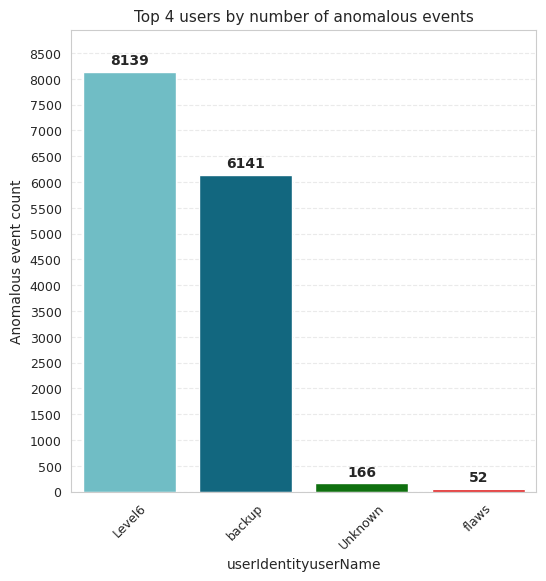

/tmp/ipykernel_47/3272295146.py:120: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  sub = sub['conf_score'].resample('6H').mean().dropna()


Saved Timeline Chart: /kaggle/working/figures/05_topk_users_timelines_styled_fixed.png


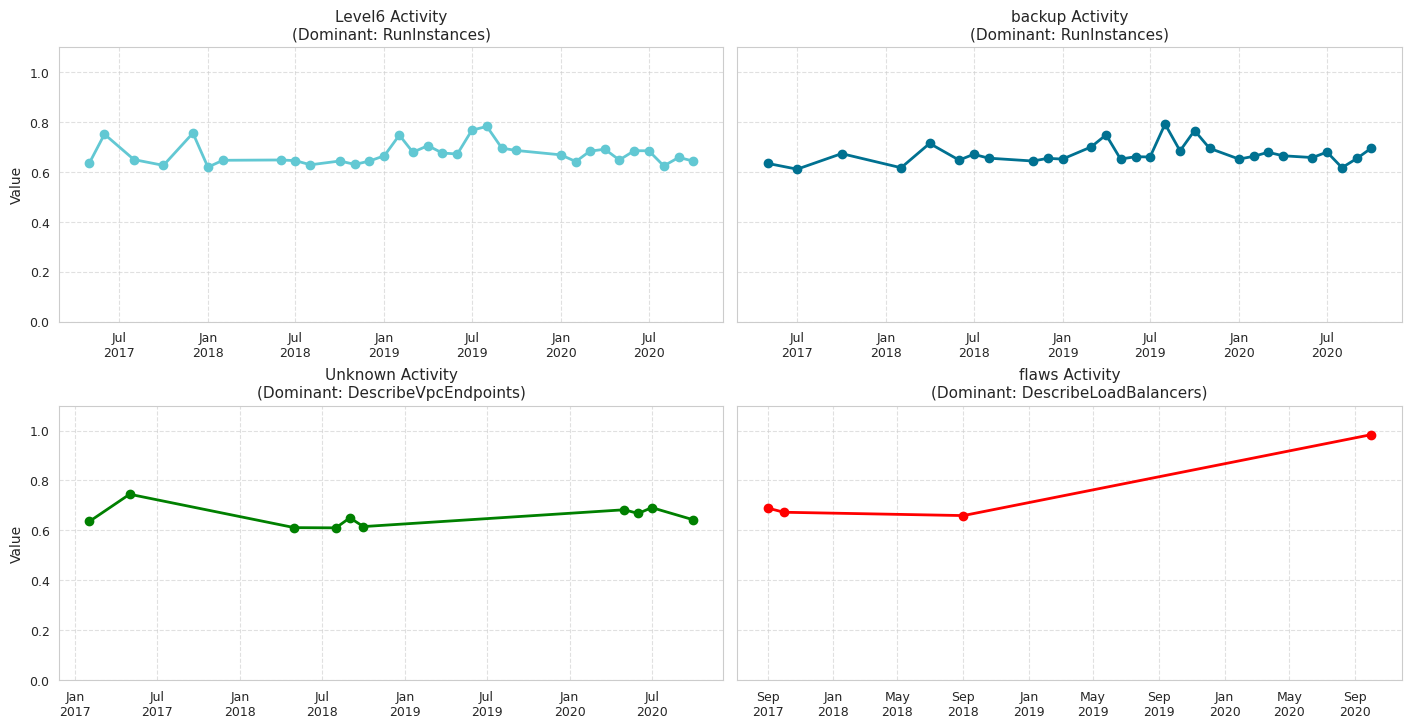


🔎 Top-K User → Anomaly Frequency & Service Context


,userIdentityuserName,anomaly_count,event_count,sum_conf,top_event,top_event_count
0,Level6,8139,8139,6172.235221,RunInstances,3516
1,backup,6141,6141,4693.801341,RunInstances,3328
2,Unknown,166,166,115.802198,DescribeVpcEndpoints,72
3,flaws,52,52,40.625522,DescribeLoadBalancers,22


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib.dates as mdates

# --- 1. Identify User and Event Columns ---
user_col = None
for cand in ['userIdentityuserName', 'userName', 'sourceIPAddress']:
    if cand in df.columns:
        user_col = cand
        break

event_col = None
for ec in ['eventName', 'eventNameEnc']:
    if ec in df.columns:
        event_col = ec
        break

if user_col is None:
    print("No user-like column found; skipping Top-K user drilldown.")

else:
    # --- 2. Data Aggregation ---
    agg = (
        df.groupby(user_col)
          .agg(
              anomaly_count=('final_label', 'sum'),
              sum_conf=('conf_score', 'sum'),      
              event_count=('conf_score', 'count')
          )
          .reset_index()
    )

    agg = agg[agg['anomaly_count'] > 0]
    agg = agg.sort_values('anomaly_count', ascending=False)

    TOPK = min(20, len(agg))
    topk = agg.head(TOPK)

    # --- 3. Identify Dominant Event per User ---
    if event_col is not None:
        top_event = (
            df[df['final_label'] == 1]             
              .groupby([user_col, event_col])
              .size()
              .reset_index(name='cnt')
              .sort_values('cnt', ascending=False)
              .drop_duplicates(user_col)
        )

        topk = topk.merge(
            top_event[[user_col, event_col, 'cnt']],
            on=user_col,
            how='left'
        ).rename(columns={
            event_col: 'top_event',
            'cnt': 'top_event_count'
        })
    else:
        topk['top_event'] = 'N/A'
        topk['top_event_count'] = 0

    # --- 4. Plotting the Bar Chart ---
    fig, ax = plt.subplots(figsize=(max(6, 0.45 * TOPK), 6))
    
    # Custom colors
    custom_colors = ['#62c8d3', '#007191', 'green', 'red' ]

    sns.barplot(
        data=topk,
        x=user_col,
        y='anomaly_count',
        palette=custom_colors,
        ax=ax
    )

    # Add count labels on top of bars
    for container in ax.containers:
        ax.bar_label(container, padding=3, fmt='%d', fontsize=10, fontweight='bold')

    ax.set_title(f"Top {TOPK} users by number of anomalous events")
    ax.set_xlabel(user_col)
    ax.set_ylabel("Anomalous event count")
    ax.yaxis.set_major_locator(MultipleLocator(500))
    
    # Dynamic Y-limit to fit labels
    max_val = topk['anomaly_count'].max()
    ax.set_ylim(0, max_val * 1.1)

    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.4)

    out_bar = FIG_DIR / f"05_top{TOPK}_users_by_anomaly_count_vertical.png"
    fig.savefig(out_bar, bbox_inches='tight', dpi=300)
    print("Saved Bar Chart:", out_bar)
    plt.show()

    # --- 5. Plotting User Timelines (FIXED) ---
    if 'eventTime' in df.columns:
        top_users = topk[user_col].tolist()[:6]

        fig, axes = plt.subplots(
            3, 2, figsize=(14, 10), 
            sharey=True,
            constrained_layout=True
        )
        axes = axes.flatten()

        for i, (ax, u) in enumerate(zip(axes, top_users)):
            # Filter data for this user
            sub = (
                df[(df[user_col] == u) & (df['final_label'] == 1)]
                  .set_index('eventTime')
                  .sort_index()
            )
            
            # --- FIX IS HERE ---
            # We explicitly select ONLY ['conf_score'] before resampling.
            # This prevents pandas from trying to average text columns.
            sub = sub['conf_score'].resample('6H').mean().dropna()

            # Match color to the bar chart
            line_color = custom_colors[i % len(custom_colors)]

            ax.plot(
                sub.index, 
                sub.values,  # Plot the values directly
                marker='o',         
                linestyle='-',      
                linewidth=2, 
                markersize=6,       
                color=line_color,   
                label='Anomaly Score'
            )

            svc = topk.loc[topk[user_col] == u, 'top_event'].values[0]

            ax.set_title(f"{u} Activity\n(Dominant: {svc})", fontsize=11)
            ax.set_ylim(0, 1.1) 
            ax.set_ylabel("Value" if i % 2 == 0 else "") 
            
            ax.grid(True, which='major', linestyle='--', alpha=0.6)
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

        for ax in axes[len(top_users):]:
            ax.set_visible(False)

        out_small = FIG_DIR / "05_topk_users_timelines_styled_fixed.png"
        fig.savefig(out_small, bbox_inches='tight', dpi=300)
        print("Saved Timeline Chart:", out_small)
        plt.show()

    # --- 6. Final Data Display ---
    print("\n🔎 Top-K User → Anomaly Frequency & Service Context")
    display(
        topk[[
            user_col,
            'anomaly_count',
            'event_count',
            'sum_conf',
            'top_event',
            'top_event_count'
        ]]
    )

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Saved: /kaggle/working/figures/02_disagreement_raw_vs_disc.png and /kaggle/working/figures/02_disagreement_delta_hist.png


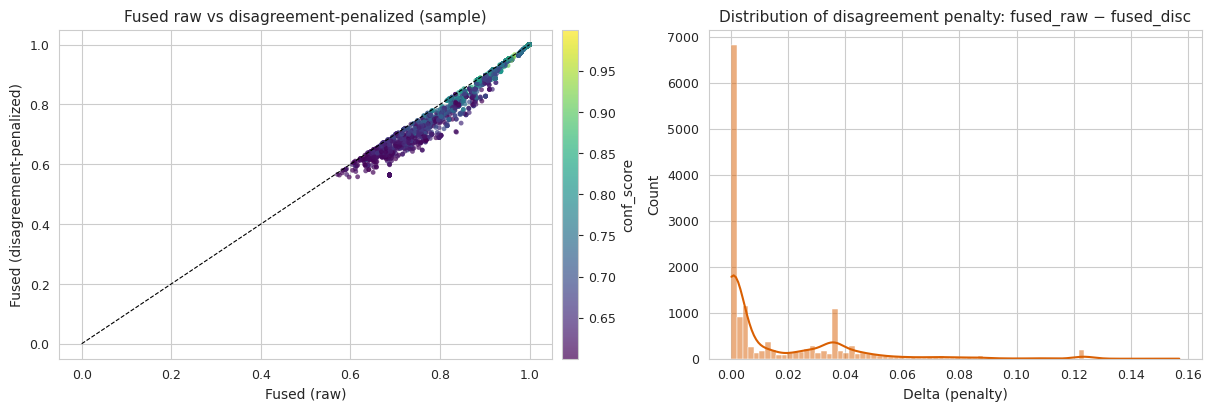

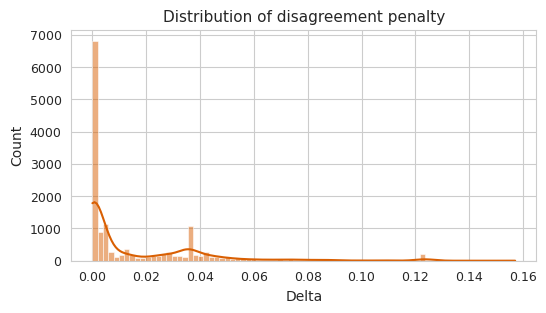

In [15]:
if ('fused_raw' not in df.columns) or ('fused_disc' not in df.columns):
    print("Missing fused_raw or fused_disc — skipping disagreement penalty visualization.")
else:
    # Sample for scatter readability
    sample = df.sample(n=min(5000, max(1000, len(df))), random_state=42)
    fig, ax = plt.subplots(1,2, figsize=(12,4), constrained_layout=True)

    sc = ax[0].scatter(sample['fused_raw'], sample['fused_disc'],
                       c=sample.get('conf_score', np.zeros(len(sample))), cmap='viridis',
                       s=12, alpha=0.7, edgecolors='none')
    ax[0].plot([0,1],[0,1],'k--', linewidth=0.8)
    ax[0].set_xlabel('Fused (raw)')
    ax[0].set_ylabel('Fused (disagreement-penalized)')
    ax[0].set_title('Fused raw vs disagreement-penalized (sample)')
    cbar = fig.colorbar(sc, ax=ax[0], pad=0.02)
    cbar.set_label('conf_score')

    # delta histogram
    df['disc_delta'] = (df['fused_raw'].fillna(0) - df['fused_disc'].fillna(0))
    sns.histplot(df['disc_delta'].dropna(), bins=80, kde=True, ax=ax[1], color='#d95f02')
    ax[1].set_title('Distribution of disagreement penalty: fused_raw − fused_disc')
    ax[1].set_xlabel('Delta (penalty)')
    ax[1].set_ylabel('Count')

    out1 = FIG_DIR / "02_disagreement_raw_vs_disc.png"
    out2 = FIG_DIR / "02_disagreement_delta_hist.png"
    fig.savefig(out1, bbox_inches='tight')
    # save the histogram separately at high quality
    fig_hist, axh = plt.subplots(figsize=(6,3))
    sns.histplot(df['disc_delta'].dropna(), bins=80, kde=True, ax=axh, color='#d95f02')
    axh.set_title('Distribution of disagreement penalty')
    axh.set_xlabel('Delta')
    fig_hist.savefig(out2, bbox_inches='tight', dpi=300)
    print("Saved:", out1, "and", out2)
    plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

NameError: name 'SUFFIX' is not defined

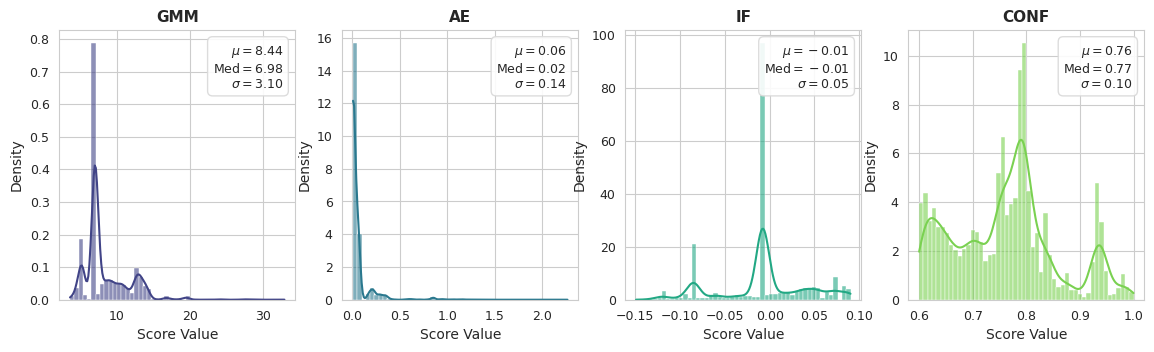

In [16]:
cols = ['score_gmm', 'score_ae', 'score_if', 'conf_score']
available = [c for c in cols if c in df.columns and df[c].notna().any()]

if available:
    ncols = len(available)
    
    fig, axes = plt.subplots(1, ncols, figsize=(3.5 * ncols, 3.5))
    if ncols == 1: axes = [axes]

    colors = sns.color_palette("viridis", n_colors=len(available))

    for ax, col, color in zip(axes, available, colors):
        data = df[col].dropna()

        
        sns.histplot(data, bins=50, kde=True, stat='density',
                     color=color, edgecolor=None, alpha=0.6, ax=ax)

        
        clean_title = col.replace('_', ' ').replace('score', '').upper().strip()
        if clean_title == "CONF SCORE": clean_title = "FUSED CONFIDENCE"

        ax.set_title(clean_title, fontweight='bold')
        ax.set_xlabel("Score Value")
        ax.set_ylabel("Density")

        
        mu, med, std = data.mean(), data.median(), data.std()
        stats_text = (f"$\mu={mu:.2f}$\n"
                      f"Med$={med:.2f}$\n"
                      f"$\sigma={std:.2f}$")
        
        ax.text(0.95, 0.95, stats_text, transform=ax.transAxes,
                fontsize=9, va='top', ha='right',
                bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="#d9d9d9", alpha=0.9))

    out_path = FIG_DIR / f"01_score_distributions{SUFFIX}.png"
    plt.savefig(out_path, bbox_inches='tight')
    print(f"Saved: {out_path}")
    plt.show()
else:
    print("No score columns found.")


📊 Total Exact Anomalies Detected: 14498


/tmp/ipykernel_47/2123451864.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled = ts.resample('1H').agg({


Saved graph to: /kaggle/working/figures/04_temporal_analysis_line_wide_tall.png


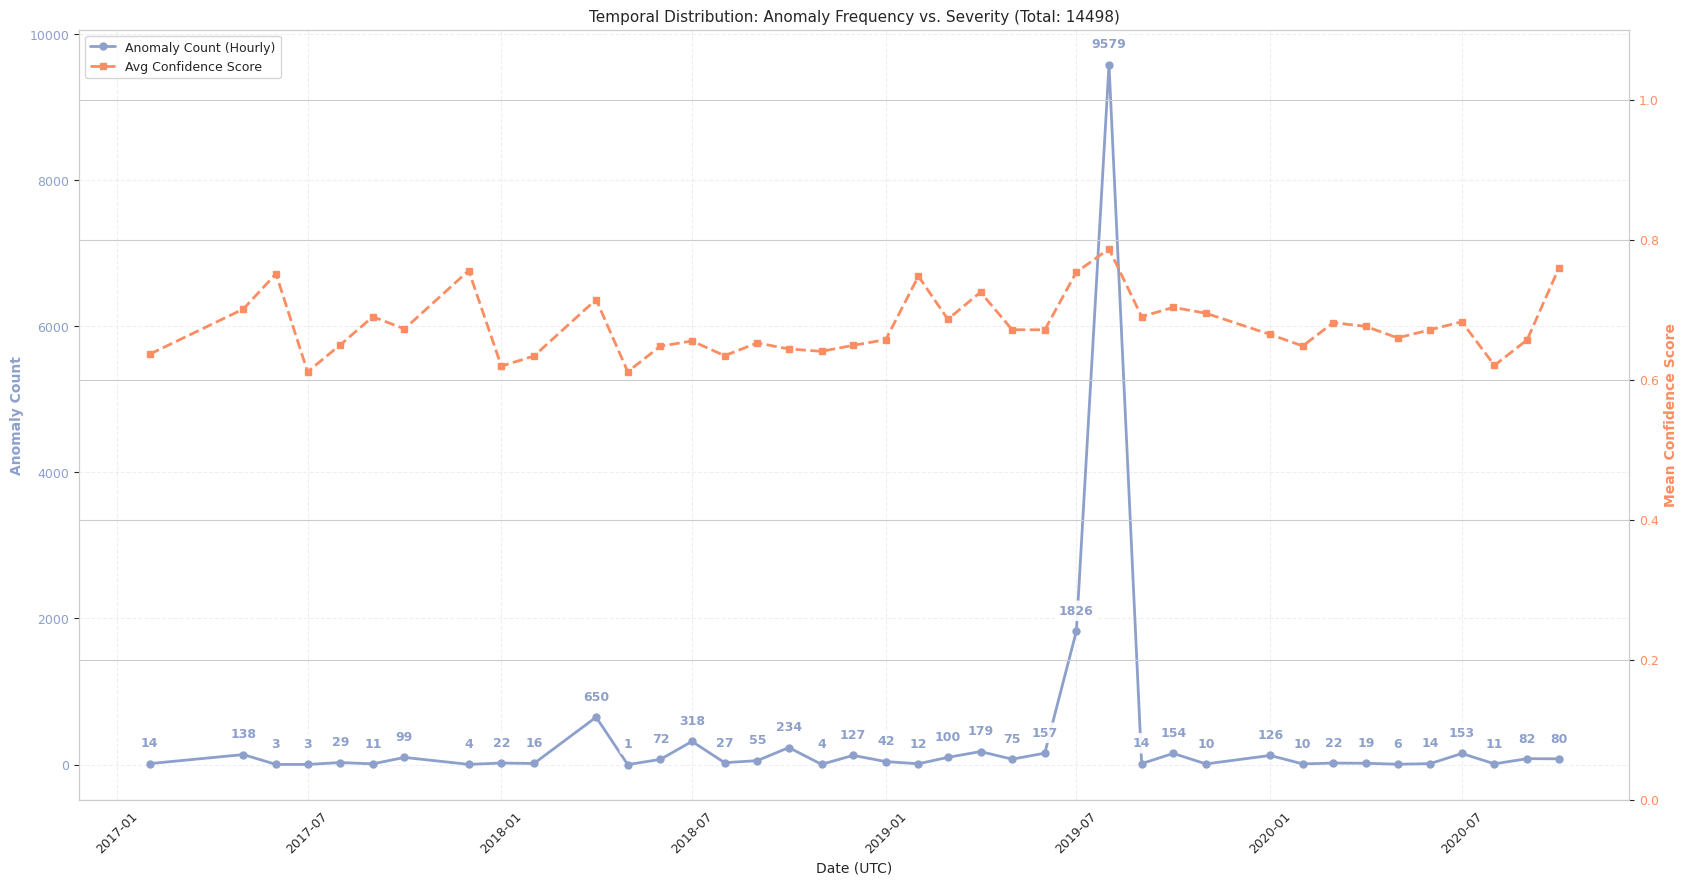

In [17]:
import matplotlib.pyplot as plt

if 'eventTime' in df.columns:
    
    # 1. Prepare Data
    ts = df.set_index('eventTime').sort_index()
    ts['is_anomaly'] = (ts['conf_score'] > 0.5).astype(int)

    # Calculate Total Exact Anomalies
    total_anomalies = ts['is_anomaly'].sum()
    print(f"\n📊 Total Exact Anomalies Detected: {total_anomalies}")
    
    # 2. Resample and Aggregation
    resampled = ts.resample('1H').agg({
        'is_anomaly': 'sum',
        'conf_score': 'mean'
    })

    # 3. Apply Dropna
    resampled = resampled.dropna()
    
    # 4. Plotting
    # --- CHANGE: Increased height from 6 to 10 ---
    fig, ax1 = plt.subplots(figsize=(20, 10)) 

    # --- Axis 1: Anomaly Count (Left) ---
    color_count = '#8da0cb' 
    ax1.plot(
        resampled.index, 
        resampled['is_anomaly'], 
        color=color_count, 
        marker='o',          
        linestyle='-',       
        linewidth=2,
        markersize=5,
        label='Anomaly Count (Hourly)'
    )
    
    # --- Add Count Labels with White Background ---
    for x, y in zip(resampled.index, resampled['is_anomaly']):
        ax1.annotate(
            f'{int(y)}',            
            xy=(x, y),              
            xytext=(0, 10),         
            textcoords='offset points',
            ha='center',
            va='bottom',            
            fontsize=9,
            color=color_count,
            fontweight='bold',
            # White box to block the line from crossing the number
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.9)
        )

    ax1.set_xlabel("Date (UTC)")
    ax1.set_ylabel("Anomaly Count", color=color_count, fontweight='bold')
    ax1.tick_params(axis='y', labelcolor=color_count)
    ax1.tick_params(axis='x', rotation=45) 
    
    ax1.grid(True, linestyle='--', alpha=0.3) 

    # --- Axis 2: Mean Confidence Score (Right) ---
    ax2 = ax1.twinx()
    color_conf = '#fc8d62'   
    ax2.plot(
        resampled.index, 
        resampled['conf_score'], 
        color=color_conf, 
        marker='s',          
        linestyle='--',      
        linewidth=2, 
        markersize=5,
        label='Avg Confidence Score'
    )
    ax2.set_ylabel("Mean Confidence Score", color=color_conf, fontweight='bold')
    ax2.tick_params(axis='y', labelcolor=color_conf)
    ax2.set_ylim(0, 1.1)

    # Title and Layout
    plt.title(f"Temporal Distribution: Anomaly Frequency vs. Severity (Total: {total_anomalies})")
    
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

    out_path = FIG_DIR / f"04_temporal_analysis_line_wide_tall.png"
    plt.savefig(out_path, bbox_inches='tight')
    print(f"Saved graph to: {out_path}")
    plt.show()

else:
    print("eventTime missing.")

NameError: name 'mtick' is not defined

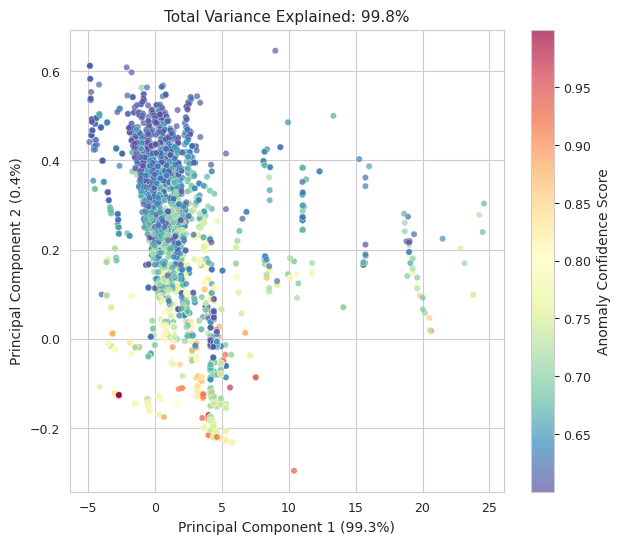

In [18]:
from sklearn.decomposition import PCA

feat_cols = ['score_gmm','score_ae','score_if','norm_gmm','norm_ae','norm_if']
features = [c for c in feat_cols if c in df.columns]

if len(features) >= 2:
    
    X = df[features].fillna(0)
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X)
    var_exp = pca.explained_variance_ratio_.sum() * 100

    
    fig, ax = plt.subplots(figsize=(7, 6))
    
    
    sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], 
                    c=df['conf_score'].fillna(0), 
                    cmap='Spectral_r', 
                    s=20, alpha=0.7, edgecolors='w', linewidth=0.2)
    
    ax.set_xlabel(f"Principal Component 1 ({pca.explained_variance_ratio_[0]:.1%})")
    ax.set_ylabel(f"Principal Component 2 ({pca.explained_variance_ratio_[1]:.1%})")
    ax.set_title(f"Total Variance Explained: {var_exp:.1f}%")
    
   
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label("Anomaly Confidence Score")
    cbar.ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))

    
    ax.grid(True, linestyle='--', alpha=0.4)

    out_path = FIG_DIR / f"07_pca_projection{SUFFIX}.png"
    plt.savefig(out_path, bbox_inches='tight')
    print(f"Saved: {out_path}")
    plt.show()
else:
    print("Not enough features for PCA.")